In [1]:
# Anomaly Detection using LSTM Encoder Decoder Architecture

#--------------------------
# Step 1 Import Libraries
#--------------------------

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras
import seaborn as sns


In [2]:
#----------------------
# Step 2 Load Dataset
# ---------------------
os.chdir('/Users/sylviachadha/Desktop/Anomaly_Detection/Practice_Dataset')
df = pd.read_csv('real_17.csv', index_col = 'timestamp')
print(df.head(6))

# Index column timestamp data type should be datetime (hourly data)
df.index.freq = 'H'
df.index
df.index = pd.to_datetime(df.index, origin=pd.Timestamp('2020-01-01'), unit = 'h')
df.index

           value  is_anomaly
timestamp                   
1              0           0
2             61           0
3           1495           0
4           1208           0
5           1347           0
6           1483           0


DatetimeIndex(['2020-01-01 01:00:00', '2020-01-01 02:00:00',
               '2020-01-01 03:00:00', '2020-01-01 04:00:00',
               '2020-01-01 05:00:00', '2020-01-01 06:00:00',
               '2020-01-01 07:00:00', '2020-01-01 08:00:00',
               '2020-01-01 09:00:00', '2020-01-01 10:00:00',
               ...
               '2020-02-28 23:00:00', '2020-02-29 00:00:00',
               '2020-02-29 01:00:00', '2020-02-29 02:00:00',
               '2020-02-29 03:00:00', '2020-02-29 04:00:00',
               '2020-02-29 05:00:00', '2020-02-29 06:00:00',
               '2020-02-29 07:00:00', '2020-02-29 08:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=1424, freq=None)

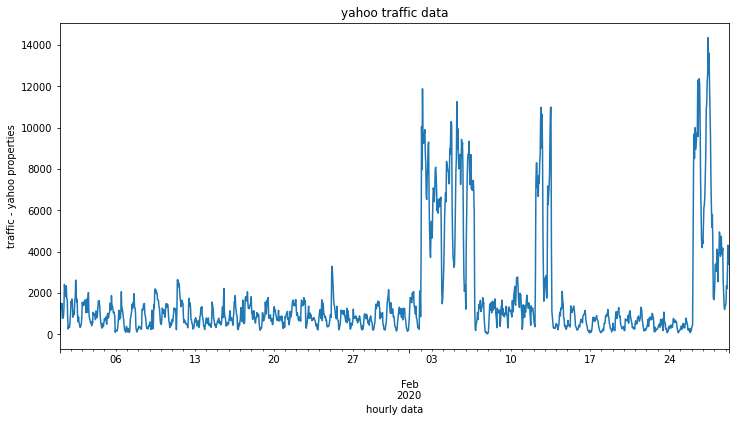

In [3]:
#-------------------
# Step3 Plot data
#-------------------
ax = df['value'].plot(figsize = (12,6), title = 'yahoo traffic data');
xlabel = 'hourly data'
ylabel = 'traffic - yahoo properties'
ax.set(xlabel = xlabel, ylabel = ylabel)
plt.show()

In [4]:
#------------------------
# Step4 Train Test Split
#------------------------
# We’ll use 90% of the data and train our model on it:
train_size = int(len(df) * 0.90)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(1281, 2) (143, 2)


In [5]:
# Store Actual labels for test data to use for confusion matrix evaluation

no_of_time_steps = 10
print(test)
len(test)
test_actual = test.iloc[no_of_time_steps:]
print(test_actual)

                     value  is_anomaly
timestamp                             
2020-02-23 10:00:00    733           0
2020-02-23 11:00:00    169           0
2020-02-23 12:00:00    327           0
2020-02-23 13:00:00   1068           0
2020-02-23 14:00:00    646           0
...                    ...         ...
2020-02-29 04:00:00   2961           1
2020-02-29 05:00:00   4302           1
2020-02-29 06:00:00   3380           1
2020-02-29 07:00:00   3688           1
2020-02-29 08:00:00   3889           1

[143 rows x 2 columns]
                     value  is_anomaly
timestamp                             
2020-02-23 20:00:00     69           0
2020-02-23 21:00:00    145           0
2020-02-23 22:00:00    152           0
2020-02-23 23:00:00    330           0
2020-02-24 00:00:00    375           0
...                    ...         ...
2020-02-29 04:00:00   2961           1
2020-02-29 05:00:00   4302           1
2020-02-29 06:00:00   3380           1
2020-02-29 07:00:00   3688           1
2

In [6]:
# Check ratio of classes (Normal vs Anomalies)
df['is_anomaly'].value_counts()

0    1197
1     227
Name: is_anomaly, dtype: int64

In [7]:
# To check how many anomalies are present in Training and how many in test
a = train.loc[train.is_anomaly == 1]
print(a)
total_rows = a['is_anomaly'].count()
print('is_anomaly_training_count',total_rows)

b = test.loc[test.is_anomaly == 1]
print(b)
total_rows = b['is_anomaly'].count()
print('is_anomaly_test_count',total_rows)


                     value  is_anomaly
timestamp                             
2020-02-02 01:00:00   3801           1
2020-02-02 02:00:00  10052           1
2020-02-02 03:00:00   7957           1
2020-02-02 04:00:00  11876           1
2020-02-02 05:00:00   9763           1
...                    ...         ...
2020-02-13 10:00:00   7791           1
2020-02-13 11:00:00   9632           1
2020-02-13 12:00:00  10924           1
2020-02-13 13:00:00  10994           1
2020-02-13 14:00:00   4217           1

[149 rows x 2 columns]
is_anomaly_training_count 149
                     value  is_anomaly
timestamp                             
2020-02-26 03:00:00   4408           1
2020-02-26 04:00:00   8059           1
2020-02-26 05:00:00   9691           1
2020-02-26 06:00:00   8507           1
2020-02-26 07:00:00   9995           1
...                    ...         ...
2020-02-29 04:00:00   2961           1
2020-02-29 05:00:00   4302           1
2020-02-29 06:00:00   3380           1
2020-02-29

In [8]:
# Remove is_anomaly = 1 rows from only train data
train = train.drop(train[train.is_anomaly == 1].index)
print('new_train_count',train['value'].count())

new_train_count 1132


In [9]:
# Just to confirm no anomaly in training set
c = train.loc[train.is_anomaly == 1]
total_rows = c['is_anomaly'].count()
print('is_anomaly_training_count',total_rows)

is_anomaly_training_count 0


In [10]:
# Anomalies still present in test set
d = test.loc[test.is_anomaly == 1]
total_rows = d['is_anomaly'].count()
print('is_anomaly_test_count',total_rows)

is_anomaly_test_count 78


In [11]:
# Remove is_anomaly column from train and test data since semi-supervised learning
del train['is_anomaly']
del test['is_anomaly']

print(train.shape, test.shape)

(1132, 1) (143, 1)


In [12]:
#-------------------------
# Step 5 Scaling of data
#-------------------------
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

<ipython-input-12-14eb7f9a16f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [13]:
#-----------------------------------
# Step 6 - Prepare Input for LSTM
#-----------------------------------
# We’ll split the data into sub-sequences - changing input to a shape as accepted by
# lstm autoencoder

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)
print(X_train.shape)

(1122, 10, 1)


In [14]:
#-----------------------------------
# Step 7 Define Model Architecture
#-----------------------------------

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

In [16]:
#----------------------------
# Step 8 Training/Fit Model
#----------------------------

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=10,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/30
101/101 [==============================] - 1s 10ms/step - loss: 0.2984 - val_loss: 0.1836
Epoch 2/30
101/101 [==============================] - 1s 10ms/step - loss: 0.2975 - val_loss: 0.1835
Epoch 3/30
101/101 [==============================] - 1s 11ms/step - loss: 0.2970 - val_loss: 0.1824
Epoch 4/30
101/101 [==============================] - 1s 10ms/step - loss: 0.2983 - val_loss: 0.1827
Epoch 5/30
101/101 [==============================] - 1s 10ms/step - loss: 0.3011 - val_loss: 0.1838
Epoch 6/30
101/101 [==============================] - 1s 10ms/step - loss: 0.2968 - val_loss: 0.1835
Epoch 7/30
101/101 [==============================] - 1s 9ms/step - loss: 0.2959 - val_loss: 0.1815
Epoch 8/30
101/101 [==============================] - 1s 9ms/step - loss: 0.2949 - val_loss: 0.1826
Epoch 9/30
101/101 [==============================] - 1s 9ms/step - loss: 0.2945 - val_loss: 0.1835
Epoch 10/30
101/101 [==============================] - 1s 10ms/step - loss: 0.2957 - val_loss:

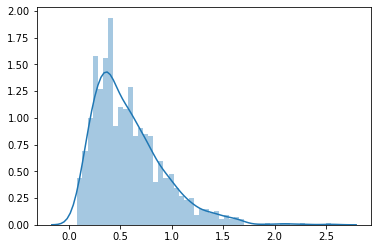

In [17]:
#------------------------------------------------------------
# Step 9 Predict & decide threshold based on Training data
#------------------------------------------------------------
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Show distribution plot of training loss
sns.distplot(train_mae_loss, bins=50, kde=True);
plt.show()

train_mae_loss = train_mae_loss.flatten()

In [18]:
#-----------------------------------------------
# Step 10 - Method to decide on Threshold value
#-----------------------------------------------
def statistical_threshold(loss_function):
    import statistics

    m = statistics.mean(loss_function)
    sd = statistics.stdev(loss_function, xbar=m)

    # 3 standard deviation as outlier
    new_std_dev = sd * 3
    threshold = m + (sd*3)

    print("Mean:", m, "SD:", sd, "New SD:", new_std_dev)
    return threshold

# Call Function
THRESHOLD = statistical_threshold(train_mae_loss)
print('statistical threshold is', THRESHOLD)

Mean: 0.5795112630606183 SD: 0.3381246237599151 New SD: 1.0143738712797452
statistical threshold is 1.5938851343403635


In [19]:
#-------------------------------------------------------
# Step 11 Predict on test data and calculate test loss
#-------------------------------------------------------
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
len(test_mae_loss)

133

In [20]:
#---------------------------------------------------------------
# Step 12 Test Result Dataframe based on Threshold pre-decided
# Condition - test_score_df.loss > test_score_df.threshold
#---------------------------------------------------------------

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['anomaly'] = test_score_df['anomaly'].astype(int)
test_score_df['value'] = test[TIME_STEPS:].value

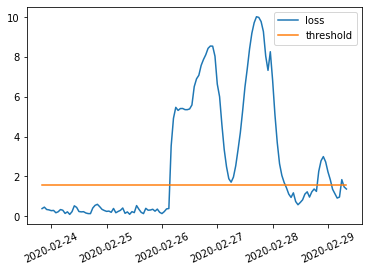

In [21]:
#--------------------------------------------
# Step 13 Plot Test Loss and Threshold
#---------------------------------------------
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();
plt.show()

In [22]:
#---------------------------------------------
# Step 14 Print Anomalies Actual and Predicted
#---------------------------------------------

anomalies = test_score_df[test_score_df.anomaly == 1]
print ('ACTUAL ANOMALIES count',len(d))
print('ACTUAL ANOMALIES',d)
print ('DETECTED ANOMALIES count',len(anomalies))
print('PREDICTED ANOMALIES', anomalies)


ACTUAL ANOMALIES count 78
ACTUAL ANOMALIES                      value  is_anomaly
timestamp                             
2020-02-26 03:00:00   4408           1
2020-02-26 04:00:00   8059           1
2020-02-26 05:00:00   9691           1
2020-02-26 06:00:00   8507           1
2020-02-26 07:00:00   9995           1
...                    ...         ...
2020-02-29 04:00:00   2961           1
2020-02-29 05:00:00   4302           1
2020-02-29 06:00:00   3380           1
2020-02-29 07:00:00   3688           1
2020-02-29 08:00:00   3889           1

[78 rows x 2 columns]
DETECTED ANOMALIES count 57
PREDICTED ANOMALIES                           loss  threshold  anomaly      value
timestamp                                                    
2020-02-26 04:00:00   3.532231   1.593885        1  10.052595
2020-02-26 05:00:00   4.921710   1.593885        1  12.311419
2020-02-26 06:00:00   5.471112   1.593885        1  10.672664
2020-02-26 07:00:00   5.317796   1.593885        1  12.732180
2020-02

In [23]:
#---------------------------------------------------------------------
# Step 15 Evaluation metrics with test_actual and test_score_df
# 1. Confusion Matrix
# 2. Accuracy
# 3. Precision
# 4. Recall
#---------------------------------------------------------------------

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_actual['is_anomaly'],test_score_df['anomaly'])
print('Confusion Matrix')
print(cf)

# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_actual['is_anomaly'],test_score_df['anomaly'])
print('Accuracy')
print(acc)

# Recall
from sklearn.metrics import recall_score
recall = recall_score(test_actual['is_anomaly'],test_score_df['anomaly'])
print('Recall')
print(recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(test_actual['is_anomaly'],test_score_df['anomaly'])
print('Precision')
print(precision)


Confusion Matrix
[[55  0]
 [21 57]]
Accuracy
0.8421052631578947
Recall
0.7307692307692307
Precision
1.0
